# A Schur Complement Method for Optimum Experimental Design in the Presence of Process Noise

Adrian Bürger (1,2), Dimitris Kouzoupis (2), Angelika Altmann-Dieses  (1), Moritz Diehl (2,3)

(1) Faculty of Management Science and Engineering, Karlsruhe University of Applied Sciences, Germany<br>
(2) Department of Microsystems Engineering, University of Freiburg, Germany<br>
(3) Department of Mathematics, University of Freiburg, Germany

## Demo - Numerical case study

### Parameter estimation of a quarter vehicle system using casiopeia 

https://github.com/adbuerger/casiopeia

![casiopeia_logo](logo.png)

### 1.) Import modules

In [1]:
import pylab as pl

import casadi as ca
import casiopeia as cp

### 2.) System definition

$$\begin{aligned}
\dot{x}_\mathrm{T}(t) = {} & v_\mathrm{T}(t) \\
\dot{v}_\mathrm{T}(t) = {} & \frac{k_\mathrm{C}}{m_\mathrm{T}}(v_\mathrm{C}(t) - v_\mathrm{T}(t)) + \frac{c_\mathrm{C}}{m_\mathrm{T}} (x_\mathrm{C}(t) - x_\mathrm{T}(t)) \\
& - \frac{c_\mathrm{T}}{m_\mathrm{T}}(x_\mathrm{T}(t) - u(t)) \\
\dot{x}_\mathrm{C}(t) = {} & v_\mathrm{C}(t) \\
\dot{v}_\mathrm{C}(t) = {} & - \frac{k_\mathrm{C}}{m_\mathrm{C}}(v_\mathrm{C}(t) - v_\mathrm{T}(t)) - \frac{c_\mathrm{C}}{m_\mathrm{C}} (x_\mathrm{C}(t) - x_\mathrm{T}(t)).
\end{aligned}$$

In [2]:
x = ca.MX.sym("x", 4)

u = ca.MX.sym("u", 1)
eps_u = ca.MX.sym("eps_u", 1)

p = ca.MX.sym("p", 3)

k_M = p[0]
c_M = p[1]
c_m = p[2]

M = 250.0
m = 50.0

p_scale = [1e3, 1e4, 1e5]

f = ca.vertcat( \

        x[1], \
        (p_scale[0] * k_M / m) * (x[3] - x[1]) + (p_scale[1] * c_M / m) * (x[2] - x[0]) - (p_scale[2] * c_m / m) * (x[0] - (u + eps_u)), \
        x[3], \
        -(p_scale[0] * k_M / M) * (x[3] - x[1]) - (p_scale[1] * c_M / M) * (x[2] - x[0]) \

    )

phi = x

system = cp.system.System( \
    x = x, u = u, p = p, f = f, phi = phi, eps_u = eps_u)


##############################################################################
#                                                                            #
#                                casiopeia 0.1                               #
#                                                                            #
#            Adrian Buerger 2014-2016, Jesus Lago Garcia 2014-2015           #
#                    SYSCOP, IMTEK, University of Freiburg                   #
#                                                                            #
##############################################################################

# ----------------------- casiopeia system definition ---------------------- #

Starting system definition ...

The system is a dynamic system defined by a set of explicit ODEs xdot
which establish the system state x and by an output function phi which
sets the system measurements:

xdot = f(u, q, x, p, eps_e, eps_u),
y = phi(u, q, x, p).

Particularly, the system

### 2.) Simulation

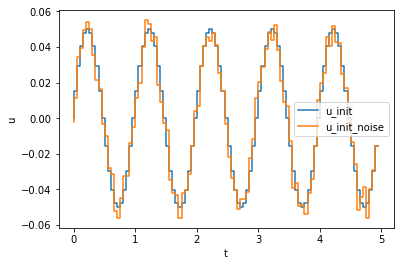

In [17]:
T = 5.0
N = 100

k_M_true = 4.0
c_M_true = 4.0
c_m_true = 1.6

p_true = [k_M_true, c_M_true, c_m_true]

time_points = pl.linspace(0, T, N+1)

u0 = 0.05
udata = u0 * pl.sin(2 * pl.pi * time_points[:-1])

simulation_true_parameters = cp.sim.Simulation( \
    system = system, pdata = p_true)

sigma_u = 0.005
udata_noise = udata + sigma_u * pl.randn(*udata.shape)


# Plot controls

f = pl.figure()
ax = pl.gca()
ax.step(time_points[:-1], udata, label = "u_init")
ax.step(time_points[:-1], udata_noise, label = "u_init_noise")
ax.legend(loc = "best")
ax.set_xlabel("t")
ax.set_ylabel("u")
pl.show()


# ----------------------- casiopeia system simulation ---------------------- #

Running system simulation, this might take some time ...

System simulation finished.


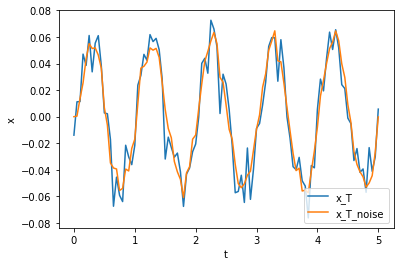

In [11]:
x0 = pl.zeros(x.shape)

simulation_true_parameters.run_system_simulation( \
    x0 = x0, time_points = time_points, udata = udata_noise)

ydata = simulation_true_parameters.simulation_results.T

sigma_y = pl.array([0.01, 0.01, 0.01, 0.01])
ydata_noise = ydata + sigma_y * pl.randn(*ydata.shape)


# Plot simulation results

f = pl.figure()
ax = pl.gca()
ax.plot(time_points, ydata_noise[:,0], label = "x_T")
ax.plot(time_points, ydata[:,0], label = "x_T_noise")
ax.legend(loc = "best")
ax.set_xlabel("t")
ax.set_ylabel("x")
pl.show()

### 3.) Parameter estimation for initial experiment

In [8]:
wv = (1.0 / sigma_y**2) * pl.ones(ydata.shape)
weps_u = (1.0 / sigma_u**2) * pl.ones(udata.shape)

pe = cp.pe.LSq(system = system, \
    time_points = time_points, \
    udata = udata, \
    pinit = [1.0, 1.0, 1.0], \
    ydata = ydata_noise, \
    xinit = ydata_noise, \
    wv = wv,
    weps_u = weps_u,
    discretization_method = "multiple_shooting")

pe.run_parameter_estimation()
pe.compute_covariance_matrix()

pe.print_estimation_results()


# -------------- casiopeia least squares parameter estimation -------------- #

Starting least squares parameter estimation using IPOPT, 
this might take some time ...

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     4408
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2010

Total number of variables............................:      911
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      804
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

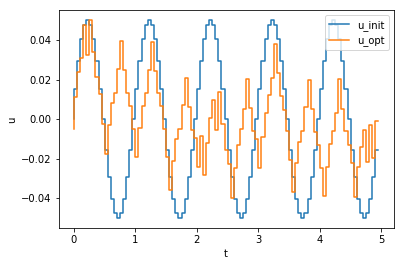

In [16]:
p_for_oed = pe.estimated_parameters

ulim = 0.05
umin = -ulim
umax = +ulim

xlim = [0.1, 0.4, 0.1, 0.4]
xmin = [-lim for lim in xlim]
xmax = [+lim for lim in xlim]

sigma_y = pl.array([0.01, 0.01, 0.01, 0.01])
sigma_u = 0.005

wv = (1.0 / sigma_y**2) * pl.ones(ydata.shape)
weps_u = (1.0 / sigma_u**2) * pl.ones(udata.shape)

doe = cp.doe.DoE(system = system, time_points = time_points, \
    uinit = udata, pdata = p_for_oed, \
    x0 = ydata[0,:], \
    wv = wv, weps_u = weps_u, \
    umin = umin, umax = umax, \
    xmin = xmin, xmax = xmax)

# doe.run_experimental_design(solver_options = {"ipopt": {"linear_solver": "ma86"}})
# u_opt = doe.design_results

u_opt = pl.loadtxt("u_opt.txt")


# Plot controls

f = pl.figure()
ax = pl.gca()
ax.step(time_points[:-1], udata, label = "u_init")
ax.step(time_points[:-1], u_opt, label = "u_opt")
ax.legend(loc = "best")
ax.set_xlabel("t")
ax.set_ylabel("u")
pl.show()